In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
import datetime
from google.colab import drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn import metrics
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset  = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/Train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(50, 50),
    shuffle=True,
    validation_split=0.2,
    seed=123,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/Train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(50, 50),
    shuffle=True,
    validation_split=0.2,
    seed=123,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
#cosa cè nel train
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

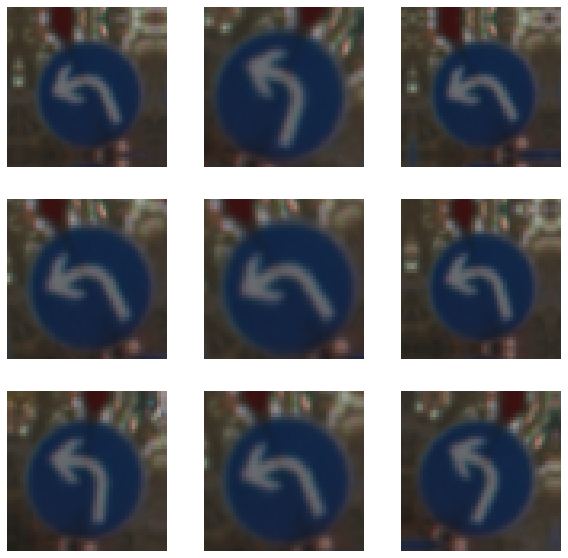

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.
# Apply `data_augmentation` to the training images.
train_dataset = train_dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = keras.Input(shape=(50, 50, 3))
#x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(inputs)
#1st Convolutional Layer
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
#2st Convolutional Layer
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
#3st Convolutional Layer
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
#4st Convolutional Layer
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
#Passing it to a Fully Connected layer
x = layers.Flatten()(x)
# 1st Fully Connected Layer
x= layers.Dense(1024,activation='relu')(x)
# 2st Fully Connected Layer
x= layers.Dense(1024,activation='relu')(x)
#Softmax layer for output
outputs = layers.Dense(43,activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(train_dataset,epochs=15,
                    validation_data=test_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=981>

# **Train and Test Set --> ok , non toccare**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from google.colab import drive
!pip install keras-tuner --upgrade

import keras_tuner as kt

from matplotlib import style
style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/'
train_path = '/content/drive/MyDrive/dataset/Train'
test_path = '/content/drive/MyDrive/dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 50
IMG_WIDTH = 50
channels = 3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
print("this is the number of sign class")
NUM_CATEGORIES

this is the number of sign class


43

In [ ]:
# Label Overview finded on internet
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

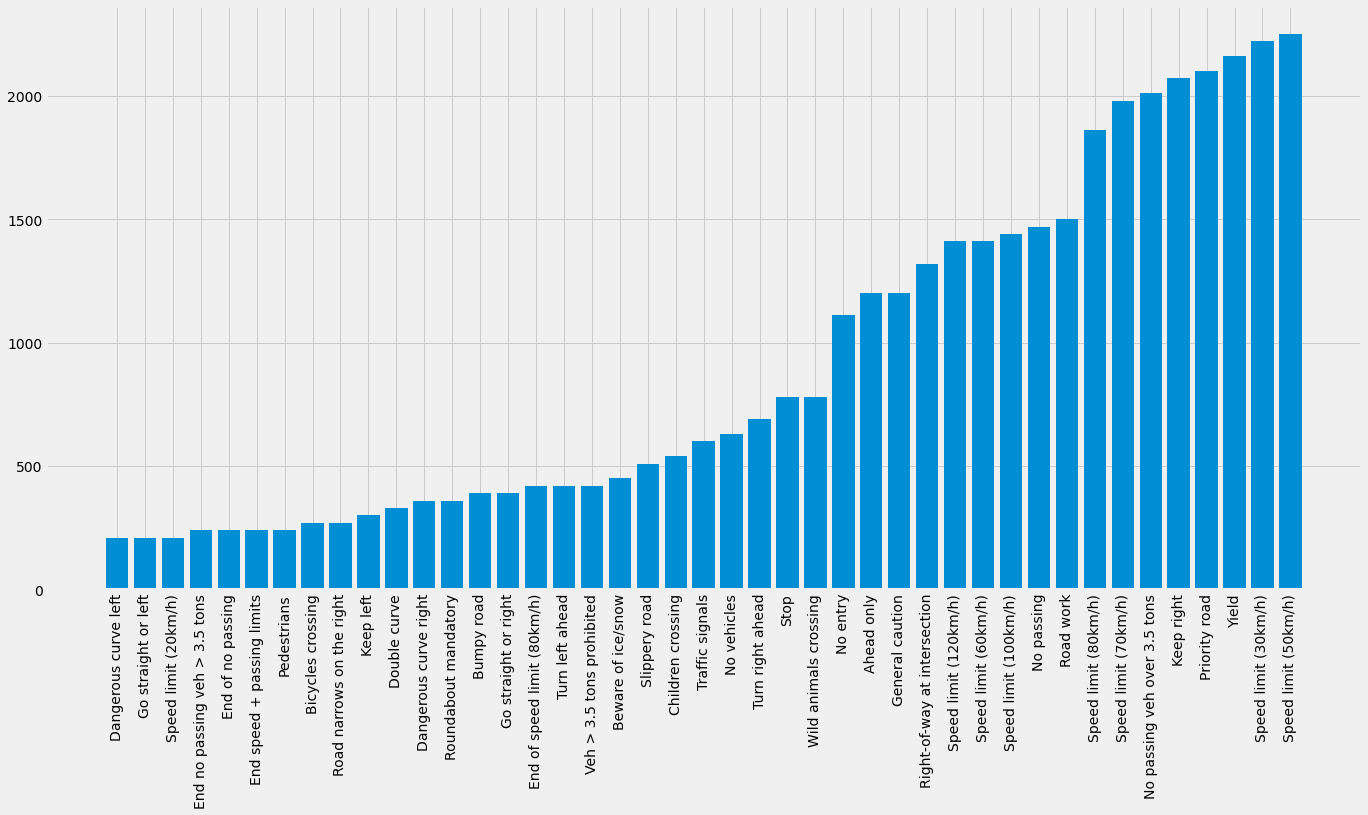

In [ ]:
#we see the distribution of our classes in the training set
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

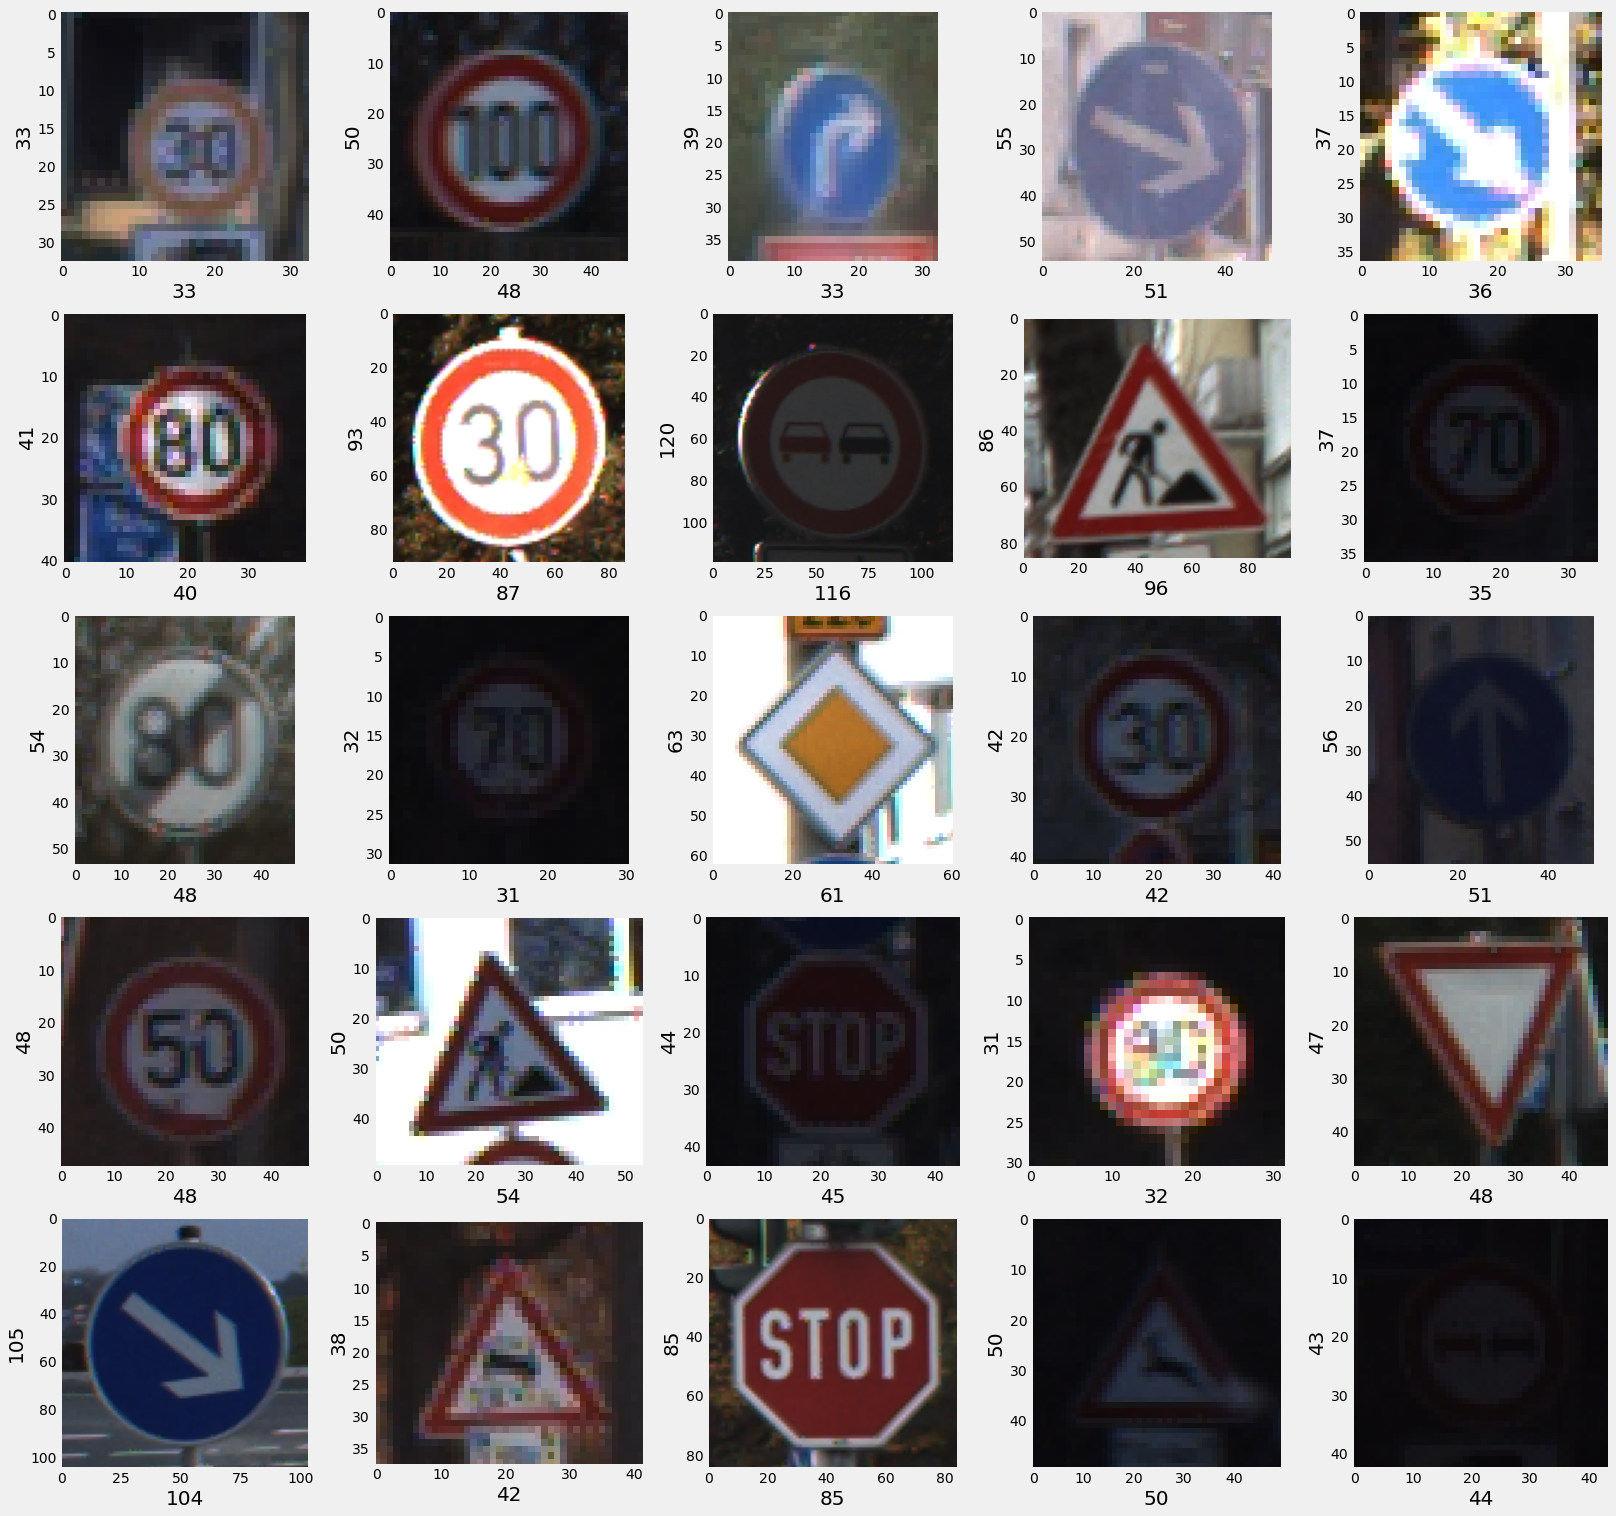

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
#we put all image with classes in np array
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 50, 50, 3) (39209,)


In [ ]:
#we mix the array, so when we go to create train, test and validation, we avoid having a predominance of classes
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [ ]:
#we split the train and test set , 80 - 20 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 50, 50, 3)
X_valid.shape (7842, 50, 50, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [ ]:
#is maded the one hot encoding to train the keras model
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
from sklearn.utils import class_weight

# TODO: aggiungere in model.fit come: model.fit(X_train, y_train, sample_weight=sample_weights)
# NOTA: Usa sample_weight, non class_weight!!!!!
# metodo corretto ma da rivedere
#sample_weights = class_weight.compute_sample_weight('balanced',
#                                                 np.unique(y_train),
                                                 y_train)
# non funziona perché abbiamo one hot encodings
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

TypeError: ignored

# **1 implementazione MNIST ---> ok , non toccare**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='sigmoid'))
model.add(keras.layers.Dense(43,activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping])

Epoch 1/15
981/981 [==============================] - ETA: 0s - loss: 1.9041 - accuracy: 0.4339

981/981 [==============================] - 176s 178ms/step - loss: 1.9041 - accuracy: 0.4339 - val_loss: 0.7695 - val_accuracy: 0.7452
Epoch 2/15
981/981 [==============================] - ETA: 0s - loss: 0.7903 - accuracy: 0.7440

981/981 [==============================] - 175s 178ms/step - loss: 0.7903 - accuracy: 0.7440 - val_loss: 0.2321 - val_accuracy: 0.9342
Epoch 3/15
981/981 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.8492

981/981 [==============================] - 174s 177ms/step - loss: 0.4687 - accuracy: 0.8492 - val_loss: 0.1001 - val_accuracy: 0.9767
Epoch 4/15
361/981 [==========>...................] - ETA: 1:58 - loss: 0.3447 - accuracy: 0.8895

KeyboardInterrupt: ignored

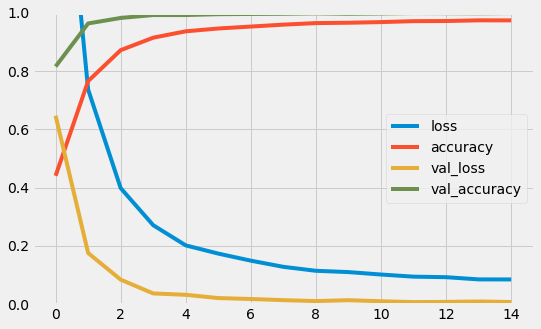

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/MNIST_save2.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/model/prova2_MNIST.h5')


#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)

predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 16s 41ms/step
Test Data accuracy:  97.79097387173397


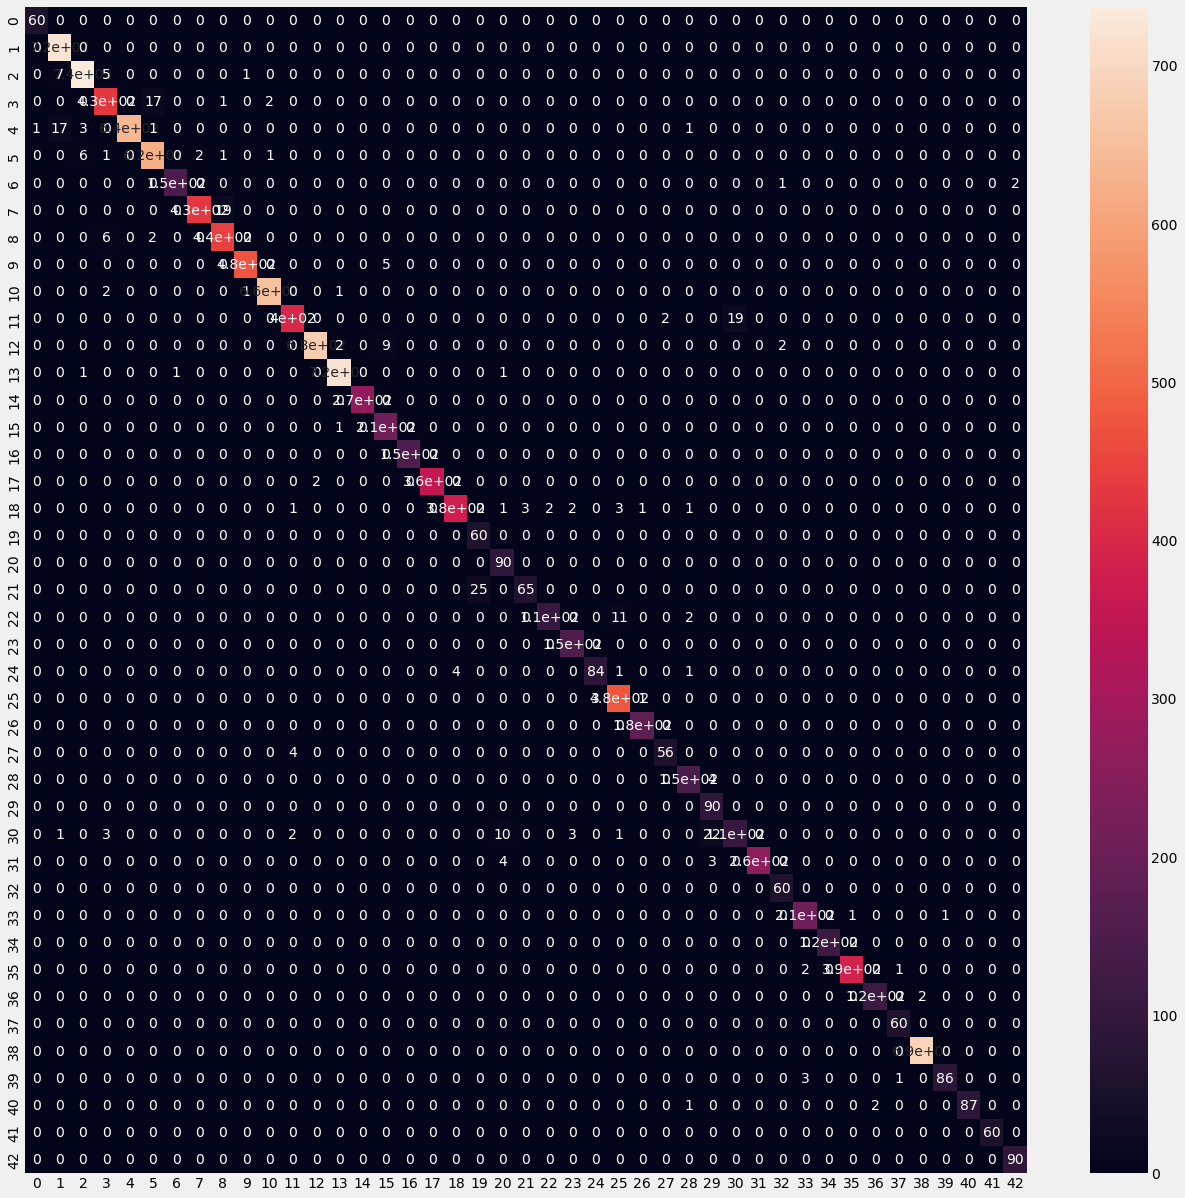

In [ ]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.97      1.00      0.98       720
           2       0.99      0.98      0.98       750
           3       0.96      0.96      0.96       450
           4       1.00      0.97      0.98       660
           5       0.97      0.98      0.98       630
           6       0.99      0.98      0.99       150
           7       1.00      0.96      0.98       450
           8       0.95      0.98      0.97       450
           9       1.00      0.99      0.99       480
          10       1.00      0.99      0.99       660
          11       0.98      0.95      0.97       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       1.00      1.00      1.00       150
          17       1.00    

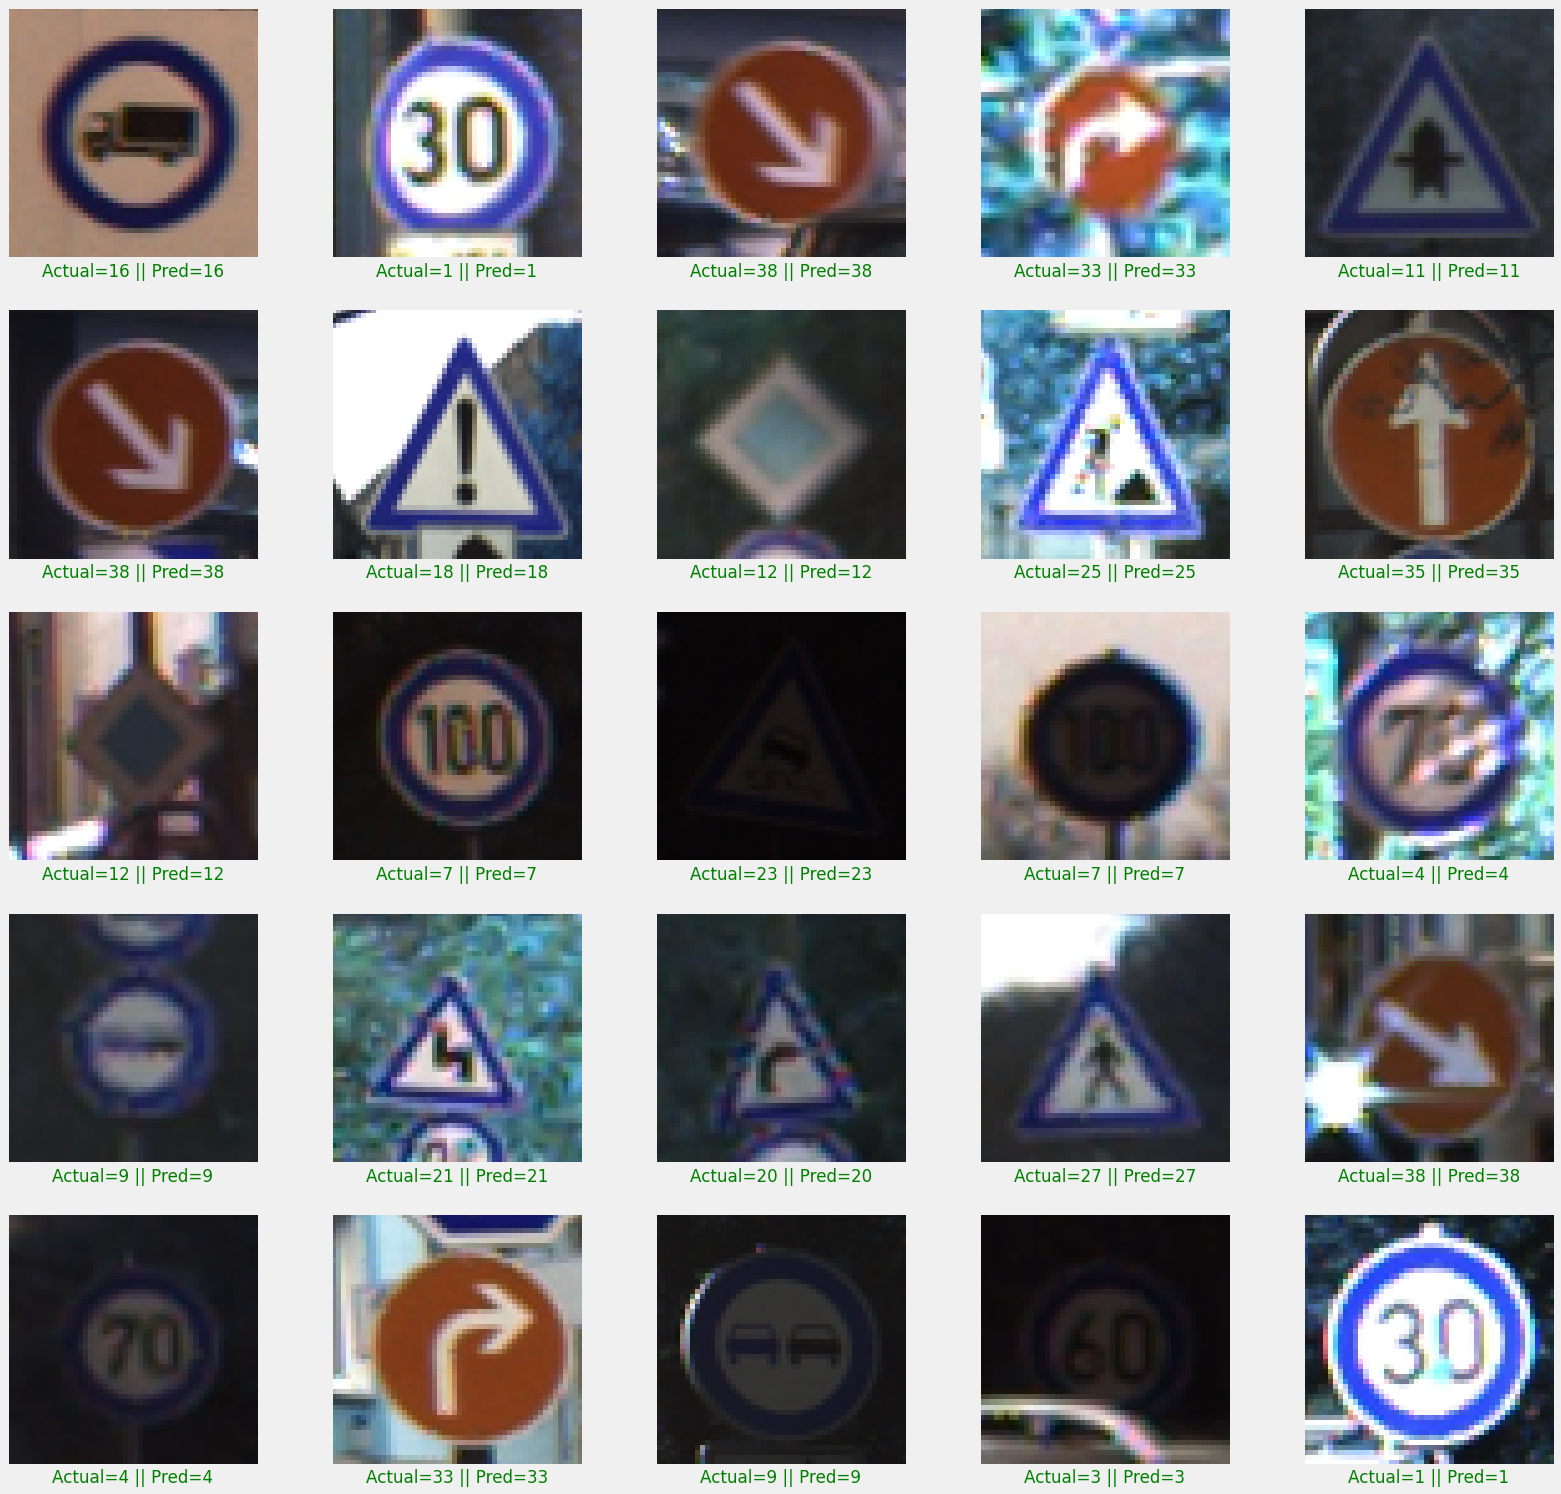

In [ ]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

# **2 implementazione ALEX  ---> ok , non toccare**

In [ ]:
model = keras.models.Sequential()
#1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#3rd Convolutional Layer
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#4th Convolutional Layer
model.add(keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#Passing it to a Fully Connected layer
model.add(keras.layers.Flatten())

# 1st Fully Connected Layer
model.add(keras.layers.Dense(1024,activation='relu'))

# 2st Fully Connected Layer
model.add(keras.layers.Dense(1024,activation='relu'))

#Softmax layer for output
model.add(keras.layers.Dense(43,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)      

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping])

Epoch 1/15
981/981 [==============================] - 290s 293ms/step - loss: 1.0042 - accuracy: 0.6958 - val_loss: 0.1941 - val_accuracy: 0.9362
Epoch 2/15
981/981 [==============================] - 284s 289ms/step - loss: 0.3349 - accuracy: 0.9055 - val_loss: 0.0906 - val_accuracy: 0.9742
Epoch 3/15
981/981 [==============================] - 277s 282ms/step - loss: 0.2488 - accuracy: 0.9332 - val_loss: 0.0499 - val_accuracy: 0.9881
Epoch 4/15
981/981 [==============================] - 278s 283ms/step - loss: 0.2232 - accuracy: 0.9444 - val_loss: 0.0544 - val_accuracy: 0.9848
Epoch 5/15
981/981 [==============================] - 275s 280ms/step - loss: 0.1917 - accuracy: 0.9531 - val_loss: 0.0432 - val_accuracy: 0.9884
Epoch 6/15
981/981 [==============================] - 282s 287ms/step - loss: 0.1873 - accuracy: 0.9568 - val_loss: 0.0668 - val_accuracy: 0.9872
Epoch 7/15
981/981 [==============================] - 282s 287ms/step - loss: 0.1752 - accuracy: 0.9603 - val_loss: 0.0395 -

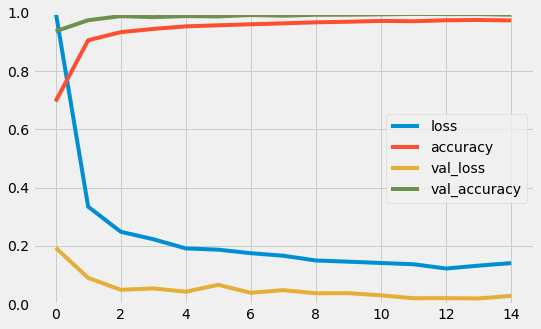

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/Alex2.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#test with the test set taken from file
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

# pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 21s 54ms/step
Test Data accuracy:  96.56373713380839


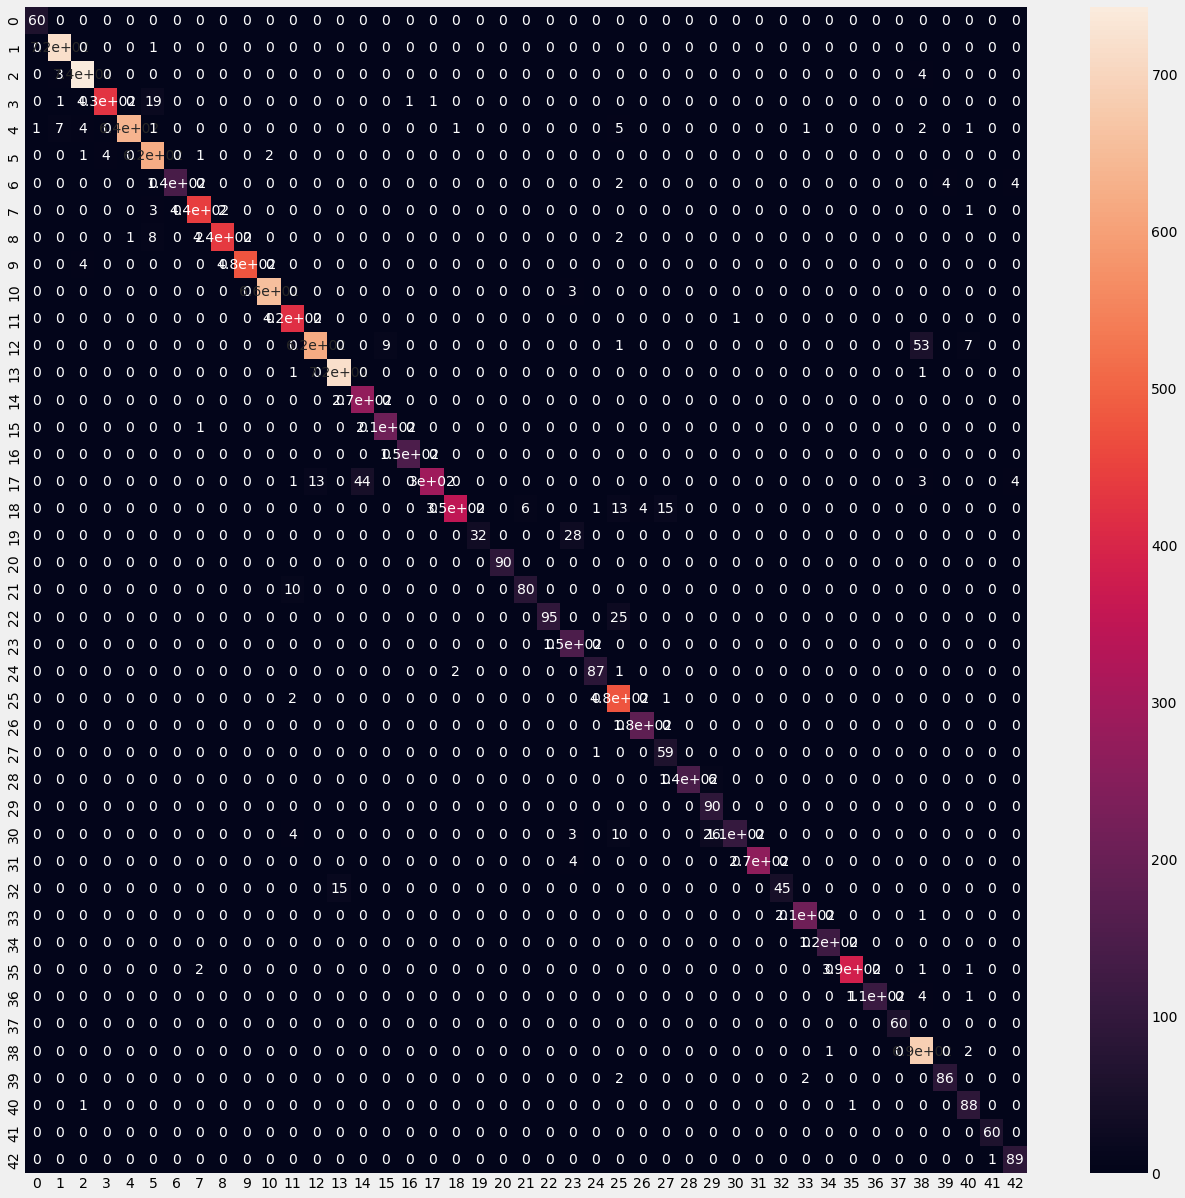

In [ ]:
#visualize confusion matrix of classifier
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [ ]:
#classification report of our model 
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.95      0.97       450
           4       1.00      0.97      0.98       660
           5       0.95      0.99      0.97       630
           6       1.00      0.93      0.97       150
           7       0.99      0.99      0.99       450
           8       1.00      0.97      0.98       450
           9       1.00      0.99      1.00       480
          10       1.00      1.00      1.00       660
          11       0.96      1.00      0.98       420
          12       0.98      0.90      0.94       690
          13       0.98      1.00      0.99       720
          14       0.86      1.00      0.92       270
          15       0.96      1.00      0.98       210
          16       0.99      1.00      1.00       150
          17       1.00    

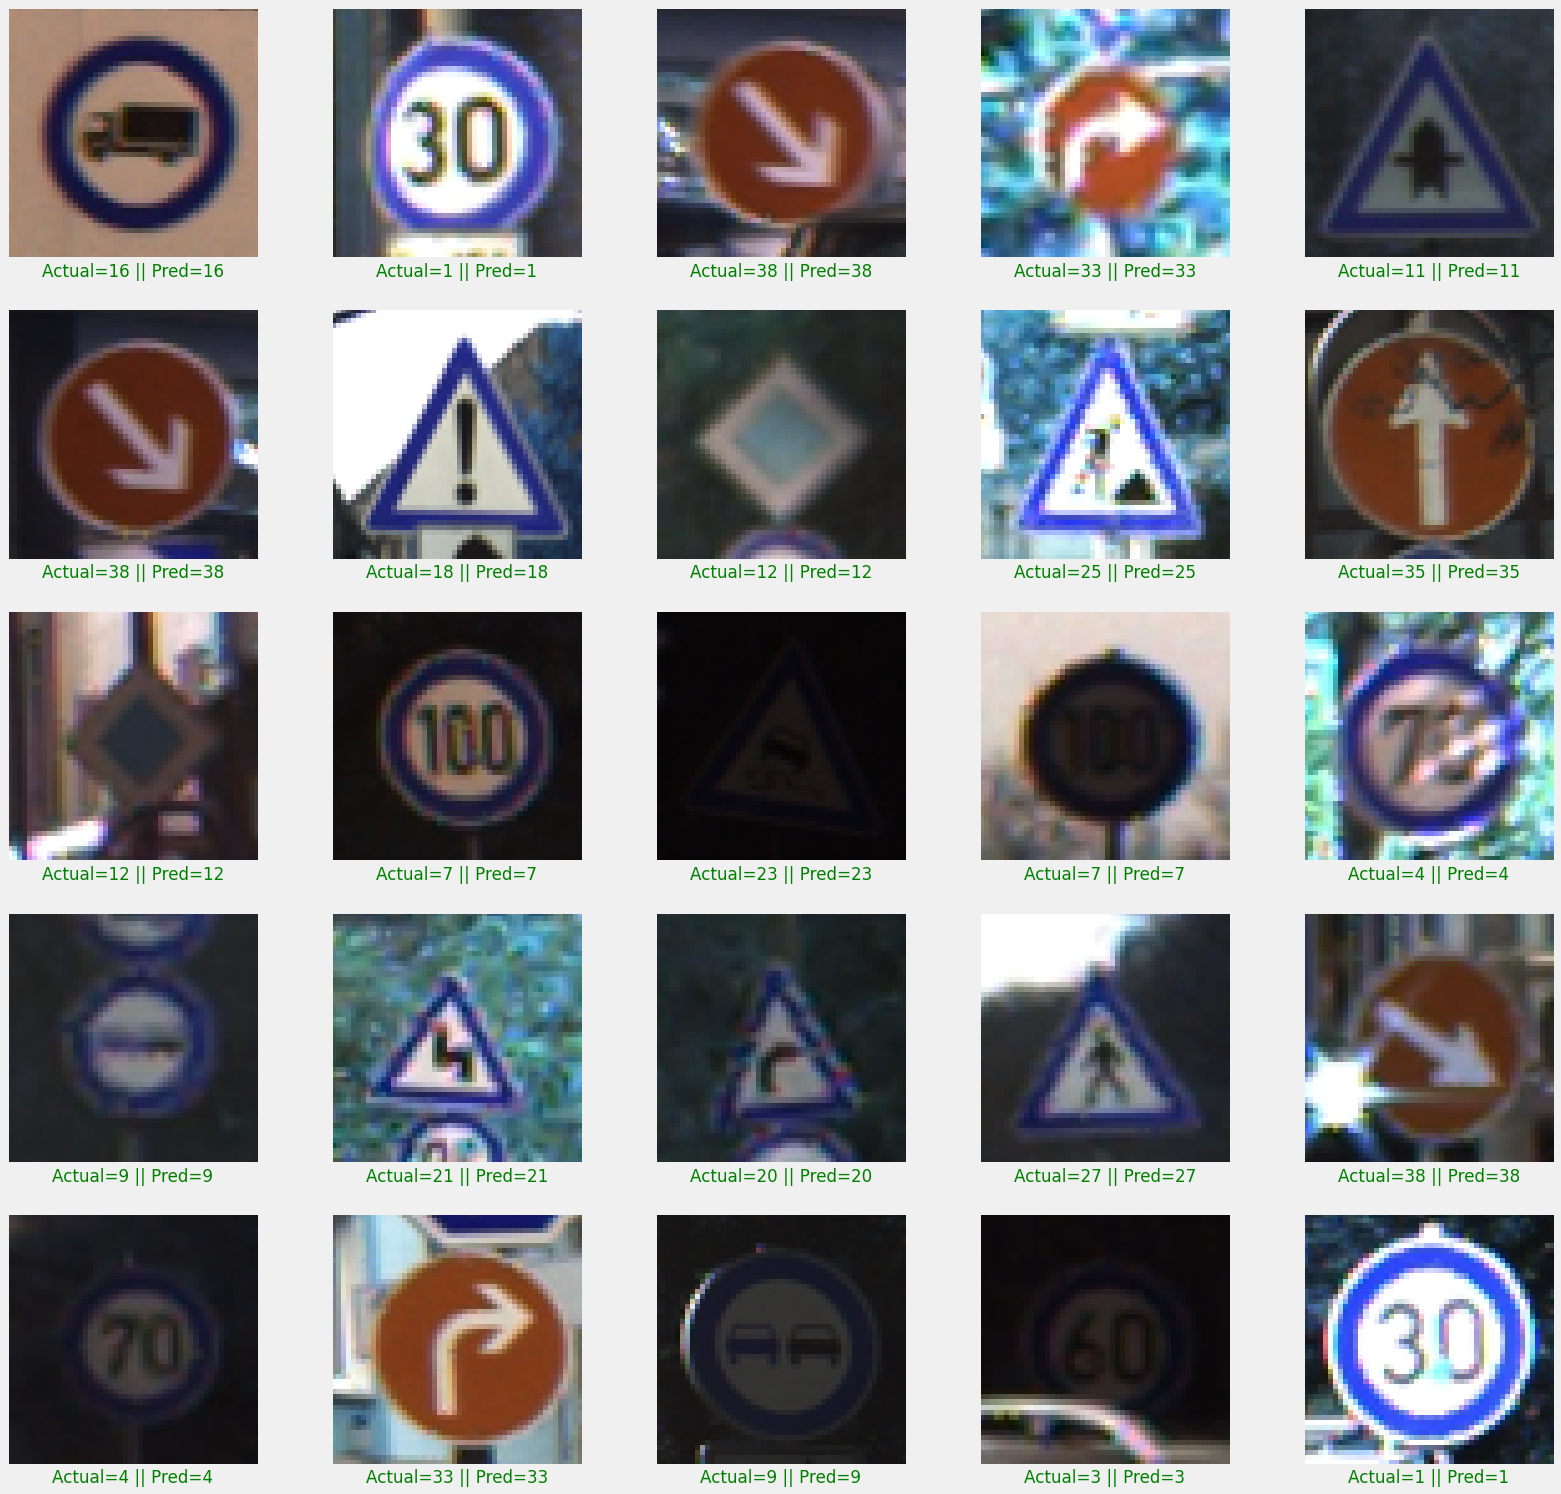

In [ ]:
#test of our classifier model
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


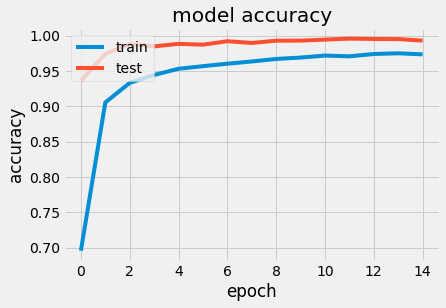

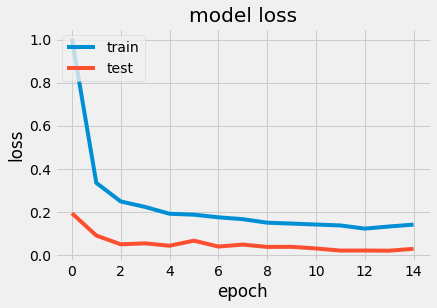

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Hyper Tuning MNIST ---> ok , non toccare**

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,3]))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,activation='sigmoid'))
  model.add(keras.layers.Dense(43,activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
import datetime
# Create permanent folder in Google Drive
my_dir = "/content/drive/My Drive/modelData/Tensorboard"
if not os.path.exists(my_dir):
  os.makedirs(my_dir)
log_dir = my_dir + "/logs/" + datetime.datetime.now().strftime("%m%d-%H%M")

In [ ]:


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=20,
                     factor=3,
                     directory=log_dir,
                     project_name='kerasTuner_mnist')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tensorboard = keras.callbacks.TensorBoard(log_dir)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early, tensorboard])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. \
        The optimal number of units in the first densely-connected layer is {best_hps.get('units')} and \
        the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")


Trial 30 Complete [00h 41m 44s]
val_accuracy: 0.9921900033950806

Best val_accuracy So Far: 0.996971607208252
Total elapsed time: 06h 59m 09s
The hyperparameter search is complete.         The optimal number of units in the first densely-connected layer is 288 and         the optimal learning rate for the optimizer is 0.001.


In [ ]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir "$log_dir"
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val) , verbose = 1 ,callbacks=[early_stopping])


val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

<IPython.core.display.Javascript object>

Epoch 1/50
981/981 [==============================] - ETA: 0s - loss: 1.8786 - accuracy: 0.4443

981/981 [==============================] - 182s 184ms/step - loss: 1.8786 - accuracy: 0.4443 - val_loss: 0.6303 - val_accuracy: 0.8191
Epoch 2/50
981/981 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7850

981/981 [==============================] - 180s 184ms/step - loss: 0.6838 - accuracy: 0.7850 - val_loss: 0.1478 - val_accuracy: 0.9616
Epoch 3/50
981/981 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8830

981/981 [==============================] - 179s 183ms/step - loss: 0.3732 - accuracy: 0.8830 - val_loss: 0.0664 - val_accuracy: 0.9860
Epoch 4/50
981/981 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9220

981/981 [==============================] - 179s 182ms/step - loss: 0.2502 - accuracy: 0.9220 - val_loss: 0.0348 - val_accuracy: 0.9923
Epoch 5/50
981/981 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9390

981/981 [==============================] - 179s 182ms/step - loss: 0.1897 - accuracy: 0.9390 - val_loss: 0.0309 - val_accuracy: 0.9916
Epoch 6/50
981/981 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9494

981/981 [==============================] - 178s 182ms/step - loss: 0.1620 - accuracy: 0.9494 - val_loss: 0.0163 - val_accuracy: 0.9959
Epoch 7/50
981/981 [==============================] - ETA: 0s - loss: 0.1428 - accuracy: 0.9557

981/981 [==============================] - 178s 182ms/step - loss: 0.1428 - accuracy: 0.9557 - val_loss: 0.0221 - val_accuracy: 0.9936
Epoch 8/50
981/981 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9608

981/981 [==============================] - 178s 182ms/step - loss: 0.1276 - accuracy: 0.9608 - val_loss: 0.0166 - val_accuracy: 0.9952
Epoch 9/50
981/981 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9647

981/981 [==============================] - 178s 182ms/step - loss: 0.1130 - accuracy: 0.9647 - val_loss: 0.0131 - val_accuracy: 0.9973
Epoch 10/50
981/981 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9662

981/981 [==============================] - 177s 181ms/step - loss: 0.1049 - accuracy: 0.9662 - val_loss: 0.0122 - val_accuracy: 0.9973
Epoch 11/50
981/981 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9707

981/981 [==============================] - 178s 182ms/step - loss: 0.0989 - accuracy: 0.9707 - val_loss: 0.0089 - val_accuracy: 0.9986
Epoch 12/50
981/981 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9707

981/981 [==============================] - 178s 181ms/step - loss: 0.0975 - accuracy: 0.9707 - val_loss: 0.0083 - val_accuracy: 0.9983
Epoch 13/50
981/981 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9723

981/981 [==============================] - 178s 182ms/step - loss: 0.0912 - accuracy: 0.9723 - val_loss: 0.0078 - val_accuracy: 0.9983
Epoch 14/50
981/981 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9741

981/981 [==============================] - 178s 182ms/step - loss: 0.0875 - accuracy: 0.9741 - val_loss: 0.0107 - val_accuracy: 0.9974
Epoch 15/50
981/981 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9744

981/981 [==============================] - 178s 182ms/step - loss: 0.0830 - accuracy: 0.9744 - val_loss: 0.0111 - val_accuracy: 0.9981
Epoch 16/50
981/981 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9755

981/981 [==============================] - 178s 181ms/step - loss: 0.0844 - accuracy: 0.9755 - val_loss: 0.0085 - val_accuracy: 0.9983
Epoch 17/50
981/981 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9766

981/981 [==============================] - 178s 181ms/step - loss: 0.0799 - accuracy: 0.9766 - val_loss: 0.0095 - val_accuracy: 0.9972
Epoch 18/50
981/981 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9771

981/981 [==============================] - 178s 181ms/step - loss: 0.0782 - accuracy: 0.9771 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 19/50
981/981 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9766

981/981 [==============================] - 178s 181ms/step - loss: 0.0796 - accuracy: 0.9766 - val_loss: 0.0077 - val_accuracy: 0.9985
Epoch 20/50
981/981 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9774

981/981 [==============================] - 178s 181ms/step - loss: 0.0764 - accuracy: 0.9774 - val_loss: 0.0064 - val_accuracy: 0.9991
Epoch 21/50
981/981 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9781

981/981 [==============================] - 178s 181ms/step - loss: 0.0734 - accuracy: 0.9781 - val_loss: 0.0073 - val_accuracy: 0.9986
Epoch 22/50
981/981 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9782

981/981 [==============================] - 178s 181ms/step - loss: 0.0779 - accuracy: 0.9782 - val_loss: 0.0070 - val_accuracy: 0.9986
Epoch 23/50
981/981 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9781

981/981 [==============================] - 178s 181ms/step - loss: 0.0756 - accuracy: 0.9781 - val_loss: 0.0069 - val_accuracy: 0.9982
Epoch 24/50
981/981 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9789

981/981 [==============================] - 178s 182ms/step - loss: 0.0727 - accuracy: 0.9789 - val_loss: 0.0069 - val_accuracy: 0.9987
Epoch 25/50
981/981 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9796

981/981 [==============================] - 178s 182ms/step - loss: 0.0715 - accuracy: 0.9796 - val_loss: 0.0080 - val_accuracy: 0.9983
Epoch 26/50
981/981 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9806

981/981 [==============================] - 178s 181ms/step - loss: 0.0702 - accuracy: 0.9806 - val_loss: 0.0078 - val_accuracy: 0.9982
Epoch 27/50
981/981 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9795

981/981 [==============================] - 178s 181ms/step - loss: 0.0760 - accuracy: 0.9795 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 28/50
981/981 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9792

981/981 [==============================] - 178s 181ms/step - loss: 0.0750 - accuracy: 0.9792 - val_loss: 0.0104 - val_accuracy: 0.9981
Epoch 29/50
981/981 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9798

981/981 [==============================] - 177s 181ms/step - loss: 0.0720 - accuracy: 0.9798 - val_loss: 0.0108 - val_accuracy: 0.9978
Epoch 30/50
981/981 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9797

981/981 [==============================] - 178s 181ms/step - loss: 0.0727 - accuracy: 0.9797 - val_loss: 0.0084 - val_accuracy: 0.9987
Epoch 31/50
981/981 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9791

981/981 [==============================] - 178s 182ms/step - loss: 0.0739 - accuracy: 0.9791 - val_loss: 0.0118 - val_accuracy: 0.9977
Epoch 32/50
981/981 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9791

981/981 [==============================] - 178s 181ms/step - loss: 0.0779 - accuracy: 0.9791 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 33/50
981/981 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9794

981/981 [==============================] - 178s 181ms/step - loss: 0.0756 - accuracy: 0.9794 - val_loss: 0.0073 - val_accuracy: 0.9987
Epoch 34/50
981/981 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9794

981/981 [==============================] - 178s 182ms/step - loss: 0.0737 - accuracy: 0.9794 - val_loss: 0.0109 - val_accuracy: 0.9982
Epoch 35/50
981/981 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9789

981/981 [==============================] - 178s 181ms/step - loss: 0.0779 - accuracy: 0.9789 - val_loss: 0.0097 - val_accuracy: 0.9987
Epoch 36/50
981/981 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9809

981/981 [==============================] - 178s 181ms/step - loss: 0.0697 - accuracy: 0.9809 - val_loss: 0.0101 - val_accuracy: 0.9981
Epoch 37/50
981/981 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9798

981/981 [==============================] - 178s 181ms/step - loss: 0.0790 - accuracy: 0.9798 - val_loss: 0.0065 - val_accuracy: 0.9994
Epoch 38/50
981/981 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9794

981/981 [==============================] - 177s 181ms/step - loss: 0.0799 - accuracy: 0.9794 - val_loss: 0.0079 - val_accuracy: 0.9989
Epoch 39/50
981/981 [==============================] - ETA: 0s - loss: 0.0681 - accuracy: 0.9814

981/981 [==============================] - 178s 181ms/step - loss: 0.0681 - accuracy: 0.9814 - val_loss: 0.0096 - val_accuracy: 0.9981
Epoch 40/50
981/981 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9802

981/981 [==============================] - 177s 181ms/step - loss: 0.0741 - accuracy: 0.9802 - val_loss: 0.0084 - val_accuracy: 0.9989
Epoch 41/50
981/981 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9820

981/981 [==============================] - 177s 181ms/step - loss: 0.0689 - accuracy: 0.9820 - val_loss: 0.0127 - val_accuracy: 0.9982
Epoch 42/50
981/981 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9801

981/981 [==============================] - 178s 181ms/step - loss: 0.0793 - accuracy: 0.9801 - val_loss: 0.0132 - val_accuracy: 0.9977
Epoch 43/50
981/981 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9791

981/981 [==============================] - 178s 181ms/step - loss: 0.0810 - accuracy: 0.9791 - val_loss: 0.0118 - val_accuracy: 0.9980
Epoch 44/50
981/981 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.9804

981/981 [==============================] - 178s 181ms/step - loss: 0.0772 - accuracy: 0.9804 - val_loss: 0.0110 - val_accuracy: 0.9986
Epoch 45/50
981/981 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.9821

981/981 [==============================] - 178s 181ms/step - loss: 0.0686 - accuracy: 0.9821 - val_loss: 0.0097 - val_accuracy: 0.9990
Epoch 46/50
981/981 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9793

981/981 [==============================] - 178s 181ms/step - loss: 0.0811 - accuracy: 0.9793 - val_loss: 0.0093 - val_accuracy: 0.9983
Epoch 47/50
981/981 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9819

981/981 [==============================] - 178s 181ms/step - loss: 0.0693 - accuracy: 0.9819 - val_loss: 0.0110 - val_accuracy: 0.9976
Epoch 48/50
981/981 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9797

981/981 [==============================] - 178s 181ms/step - loss: 0.0797 - accuracy: 0.9797 - val_loss: 0.0074 - val_accuracy: 0.9992
Epoch 49/50
981/981 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9793

981/981 [==============================] - 178s 181ms/step - loss: 0.0808 - accuracy: 0.9793 - val_loss: 0.0079 - val_accuracy: 0.9990
Epoch 50/50
981/981 [==============================] - ETA: 0s - loss: 0.0765 - accuracy: 0.9788

981/981 [==============================] - 178s 181ms/step - loss: 0.0765 - accuracy: 0.9788 - val_loss: 0.0089 - val_accuracy: 0.9987
Best epoch: 37


In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(aug.flow(X_train, y_train, batch_size=32), epochs=best_epoch,  validation_data=(X_val, y_val) , verbose = 1 , callbacks=[early_stopping])



Epoch 1/37
981/981 [==============================] - ETA: 0s - loss: 1.8225 - accuracy: 0.4566

981/981 [==============================] - 181s 183ms/step - loss: 1.8225 - accuracy: 0.4566 - val_loss: 0.5830 - val_accuracy: 0.8374
Epoch 2/37
981/981 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.7805

981/981 [==============================] - 179s 183ms/step - loss: 0.6898 - accuracy: 0.7805 - val_loss: 0.1793 - val_accuracy: 0.9517
Epoch 3/37
981/981 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8781

981/981 [==============================] - 179s 182ms/step - loss: 0.3899 - accuracy: 0.8781 - val_loss: 0.0705 - val_accuracy: 0.9828
Epoch 4/37
981/981 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9130

981/981 [==============================] - 179s 182ms/step - loss: 0.2705 - accuracy: 0.9130 - val_loss: 0.0393 - val_accuracy: 0.9912
Epoch 5/37
981/981 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9334

981/981 [==============================] - 179s 182ms/step - loss: 0.2093 - accuracy: 0.9334 - val_loss: 0.0342 - val_accuracy: 0.9908
Epoch 6/37
981/981 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9457

981/981 [==============================] - 178s 181ms/step - loss: 0.1701 - accuracy: 0.9457 - val_loss: 0.0204 - val_accuracy: 0.9948
Epoch 7/37
981/981 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9542

981/981 [==============================] - 178s 182ms/step - loss: 0.1415 - accuracy: 0.9542 - val_loss: 0.0194 - val_accuracy: 0.9954
Epoch 8/37
981/981 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9568

981/981 [==============================] - 178s 181ms/step - loss: 0.1340 - accuracy: 0.9568 - val_loss: 0.0189 - val_accuracy: 0.9944
Epoch 9/37
981/981 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9614

981/981 [==============================] - 177s 181ms/step - loss: 0.1228 - accuracy: 0.9614 - val_loss: 0.0112 - val_accuracy: 0.9974
Epoch 10/37
981/981 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9652

981/981 [==============================] - 178s 181ms/step - loss: 0.1149 - accuracy: 0.9652 - val_loss: 0.0153 - val_accuracy: 0.9963
Epoch 11/37
981/981 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.9663

981/981 [==============================] - 178s 181ms/step - loss: 0.1071 - accuracy: 0.9663 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 12/37
981/981 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9676

981/981 [==============================] - 178s 181ms/step - loss: 0.1032 - accuracy: 0.9676 - val_loss: 0.0093 - val_accuracy: 0.9980
Epoch 13/37
981/981 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9702

981/981 [==============================] - 178s 181ms/step - loss: 0.1003 - accuracy: 0.9702 - val_loss: 0.0105 - val_accuracy: 0.9976
Epoch 14/37
981/981 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9713

981/981 [==============================] - 177s 180ms/step - loss: 0.0955 - accuracy: 0.9713 - val_loss: 0.0109 - val_accuracy: 0.9977
Epoch 15/37
981/981 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9718

981/981 [==============================] - 176s 180ms/step - loss: 0.0909 - accuracy: 0.9718 - val_loss: 0.0126 - val_accuracy: 0.9971
Epoch 16/37
981/981 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9733

981/981 [==============================] - 176s 180ms/step - loss: 0.0879 - accuracy: 0.9733 - val_loss: 0.0083 - val_accuracy: 0.9983
Epoch 17/37
981/981 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9756

981/981 [==============================] - 176s 179ms/step - loss: 0.0829 - accuracy: 0.9756 - val_loss: 0.0096 - val_accuracy: 0.9982
Epoch 18/37
981/981 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9743

981/981 [==============================] - 176s 180ms/step - loss: 0.0884 - accuracy: 0.9743 - val_loss: 0.0150 - val_accuracy: 0.9971
Epoch 19/37
981/981 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9740

981/981 [==============================] - 176s 179ms/step - loss: 0.0885 - accuracy: 0.9740 - val_loss: 0.0111 - val_accuracy: 0.9973
Epoch 20/37
981/981 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9754

981/981 [==============================] - 176s 179ms/step - loss: 0.0828 - accuracy: 0.9754 - val_loss: 0.0111 - val_accuracy: 0.9981
Epoch 21/37
981/981 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9753

981/981 [==============================] - 176s 180ms/step - loss: 0.0836 - accuracy: 0.9753 - val_loss: 0.0116 - val_accuracy: 0.9976
Epoch 22/37
981/981 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9737

981/981 [==============================] - 176s 180ms/step - loss: 0.0889 - accuracy: 0.9737 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 23/37
981/981 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9754

981/981 [==============================] - 175s 178ms/step - loss: 0.0853 - accuracy: 0.9754 - val_loss: 0.0113 - val_accuracy: 0.9974
Epoch 24/37
981/981 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9755

981/981 [==============================] - 172s 176ms/step - loss: 0.0821 - accuracy: 0.9755 - val_loss: 0.0068 - val_accuracy: 0.9989
Epoch 25/37
981/981 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9778

981/981 [==============================] - 171s 174ms/step - loss: 0.0764 - accuracy: 0.9778 - val_loss: 0.0121 - val_accuracy: 0.9974
Epoch 26/37
981/981 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9775

981/981 [==============================] - 171s 174ms/step - loss: 0.0827 - accuracy: 0.9775 - val_loss: 0.0118 - val_accuracy: 0.9978
Epoch 27/37
981/981 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9765

981/981 [==============================] - 171s 174ms/step - loss: 0.0851 - accuracy: 0.9765 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 28/37
981/981 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9783

981/981 [==============================] - 171s 174ms/step - loss: 0.0758 - accuracy: 0.9783 - val_loss: 0.0316 - val_accuracy: 0.9925
Epoch 29/37
981/981 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9768

981/981 [==============================] - 171s 174ms/step - loss: 0.0819 - accuracy: 0.9768 - val_loss: 0.0108 - val_accuracy: 0.9987
Epoch 30/37
981/981 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9781

981/981 [==============================] - 171s 174ms/step - loss: 0.0795 - accuracy: 0.9781 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 31/37
981/981 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9779

981/981 [==============================] - 171s 174ms/step - loss: 0.0756 - accuracy: 0.9779 - val_loss: 0.0158 - val_accuracy: 0.9967
Epoch 32/37
981/981 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9778

981/981 [==============================] - 171s 174ms/step - loss: 0.0878 - accuracy: 0.9778 - val_loss: 0.0104 - val_accuracy: 0.9987
Epoch 33/37
981/981 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9776

981/981 [==============================] - 174s 177ms/step - loss: 0.0788 - accuracy: 0.9776 - val_loss: 0.0111 - val_accuracy: 0.9985
Epoch 34/37
981/981 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9779

981/981 [==============================] - 178s 182ms/step - loss: 0.0810 - accuracy: 0.9779 - val_loss: 0.0088 - val_accuracy: 0.9990
Epoch 35/37
981/981 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9772

981/981 [==============================] - 178s 182ms/step - loss: 0.0823 - accuracy: 0.9772 - val_loss: 0.0113 - val_accuracy: 0.9972
Epoch 36/37
665/981 [===================>..........] - ETA: 54s - loss: 0.0901 - accuracy: 0.9751

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/tuned_model.h5')   # always save your weights after training or during training


In [ ]:
hypermodel.save('/content/drive/MyDrive/dataset/model/hyper.h5')   # always save your weights after training or during training


# **Import a pretrained neural network**

### Instantiate the VGG19 convolutional base

In [ ]:
from tensorflow.keras.applications import VGG19

conv_base = keras.applications.vgg19.VGG19(
 weights="imagenet",
 include_top=False,
 input_shape=(50, 50, 3)
 )

NameError: ignored

In [ ]:
conv_base.summary()

### Feature extraction with data augmentation

In [ ]:
conv_base = keras.applications.vgg19.VGG19(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False
#Setting trainable to False empties the list of trainable weights of the layer or model

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(50, 50, 3))
x = data_augmentation(inputs) # apply data augmentation
x = keras.applications.vgg19.preprocess_input(x) # apply input value scaling
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction_with_data_augmentation.keras",
 save_best_only=True,
 monitor="val_loss")
]

history = model.fit(
 #train_features, train_labels,
 X_train, y_train,
 epochs=50,
 #validation_data=(val_features, val_labels),
 validation_data=(X_val, y_val),
 callbacks=callbacks

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras")
#test_loss, test_acc = test_model.evaluate(test_dataset)
test_loss, test_acc = test_model.evaluate(X_test, labels)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
conv_base.summary()
# we can see which layers we should fine tune; it's not convenient to fine tune all the layers; earlier layers are more generic,
# while higher layers are more specialized; also if we fine tune too much layers we risk overfitting

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine Tuning

In [ ]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
 layer.trainable = False

In [ ]:
conv_base.summary()

Fine tuning with the RMSprop optimizer

In [ ]:
model.compile(loss="binary_crossentropy",
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=["accuracy"])

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.keras",
 save_best_only=True,
 monitor="val_loss")
]

history = model.fit(
 #train_dataset,
 X_train, y_train,
 epochs=30,
 validation_data=X_val, y_val,
 #validation_data=validation_dataset,
 callbacks=callbacks

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
#test_loss, test_acc = model.evaluate(test_dataset)
test_loss, test_acc = test_model.evaluate(X_test, labels) 
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Pova con YOLO (opzionale)**